In [5]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [22]:
datasets = {
            'rna': '../data/luad/LUAD_RNASeq.csv',
            'cnv': '../data/luad/LUAD_CNV.csv',
            'methylation': '../data/luad/LUAD_Methylation.csv',
}
        
labels = '../data/luad/LUAD_Clinical.csv'

In [23]:
#subtypes = pd.read_csv(labels, index_col=0)
#subtypes_2 = pd.read_csv(labels_2, index_col=0)
survival = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0).astype(float)
    print(modality, data[modality].shape)

rna (426, 19988)
cnv (426, 24776)
methylation (426, 20115)


# Preprocessing

## Removing low-variance + null features

In [9]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    return X_new

In [99]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], 0.05)
    print(modality, new_data[modality].shape)

rna (431, 19404)
cnv (431, 24776)
methylation (431, 32)


In [24]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in data:
    X[modality] = pd.DataFrame(data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (426, 19988)
cnv (426, 24776)
methylation (426, 19030)


In [25]:
survival['survival_days']

SubjectID
TCGA.05.4384     426.0
TCGA.05.4390    1126.0
TCGA.05.4396     303.0
TCGA.05.4405     610.0
TCGA.05.4415      91.0
                 ...  
TCGA.NJ.A4YQ    1432.0
TCGA.NJ.A55R     603.0
TCGA.NJ.A7XG     617.0
TCGA.O1.A52J    1798.0
TCGA.S2.AA1A     513.0
Name: survival_days, Length: 426, dtype: float64

In [26]:
# Create 3 evenly spaced bins
labels = ["low", "medium", "high"]
s_cut = pd.qcut(survival['survival_days'], q=3, labels=labels)
s_cut

SubjectID
TCGA.05.4384       low
TCGA.05.4390      high
TCGA.05.4396       low
TCGA.05.4405    medium
TCGA.05.4415       low
                 ...  
TCGA.NJ.A4YQ      high
TCGA.NJ.A55R    medium
TCGA.NJ.A7XG    medium
TCGA.O1.A52J      high
TCGA.S2.AA1A    medium
Name: survival_days, Length: 426, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [28]:
s_cut.value_counts()

low       142
medium    142
high      142
Name: survival_days, dtype: int64

In [29]:
enc = LabelEncoder()
#y = enc.fit_transform(subtypes['pathologic_stage'])
#y_2 = enc.fit_transform(subtypes_2['histological_type'])
y = enc.fit_transform(s_cut)

In [30]:
enc.inverse_transform([0, 1, 2])

array(['high', 'low', 'medium'], dtype=object)

# Base Learners

In [11]:
from imblearn.pipeline import make_pipeline

In [33]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [23]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (i)': make_scorer(recall_multiclass, label=0), 'recall (ii)': make_scorer(recall_multiclass, label=1), 'recall (iii)': make_scorer(recall_multiclass, label=2), 'recall (iv)': make_scorer(recall_multiclass, label=3)})

 25%|██▌       | 1/4 [01:06<03:20, 66.84s/it]

logistic                  accuracy balanced_accuracy               f1       recall (i)  \
logistic  0.502 +/- 0.030   0.278 +/- 0.019  0.457 +/- 0.028  0.791 +/- 0.055   

              recall (ii)     recall (iii)      recall (iv)  
logistic  0.198 +/- 0.032  0.125 +/- 0.089  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.301 +/- 0.065   0.312 +/- 0.097  0.337 +/- 0.070   

                             recall (i)      recall (ii)     recall (iii)  \
balanced_random_forest  0.340 +/- 0.047  0.225 +/- 0.123  0.250 +/- 0.113   

                            recall (iv)  
balanced_random_forest  0.433 +/- 0.162  


 75%|███████▌  | 3/4 [01:51<00:33, 33.68s/it]

deep_nn                 accuracy balanced_accuracy               f1       recall (i)  \
deep_nn  0.469 +/- 0.025   0.287 +/- 0.034  0.448 +/- 0.026  0.676 +/- 0.030   

             recall (ii)     recall (iii)      recall (iv)  
deep_nn  0.251 +/- 0.056  0.221 +/- 0.134  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [02:07<00:0

svc             accuracy balanced_accuracy               f1       recall (i)  \
svc  0.502 +/- 0.029   0.274 +/- 0.017  0.456 +/- 0.027  0.803 +/- 0.052   

         recall (ii)     recall (iii)      recall (iv)  
svc  0.180 +/- 0.029  0.111 +/- 0.069  0.000 +/- 0.000  


  0%|          | 0/4 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

logistic                  accuracy balanced_accuracy               f1       recall (i)  \
logistic  0.395 +/- 0.049   0.248 +/- 0.039  0.394 +/- 0.047  0.554 +/- 0.066   

              recall (ii)     recall (iii)      recall (iv)  
logistic  0.243 +/- 0.062  0.195 +/- 0.067  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.211 +/- 0.034   0.184 +/- 0.051  0.248 +/- 0.038   

                             recall (i)      recall (ii)     recall (iii)  \
balanced_random_forest  0.201 +/- 0.035  0.225 +/- 0.048  0.259 +/- 0.151   

                            recall (iv)  
balanced_random_forest  0.050 +/- 0.100  


 75%|███████▌  | 3/4 [03:45<01:06, 66.43s/it]

deep_nn                 accuracy balanced_accuracy               f1       recall (i)  \
deep_nn  0.388 +/- 0.007   0.235 +/- 0.023  0.376 +/- 0.006  0.586 +/- 0.038   

             recall (ii)     recall (iii)      recall (iv)  
deep_nn  0.189 +/- 0.032  0.113 +/- 0.097  0.050 +/- 0.100  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1       recall (i)  \
svc  0.399 +/- 0.035   0.229 +/- 0.026  0.390 +/- 0.034  0.595 +/- 0.058   

         recall (ii)     recall (iii)      recall (iv)  
svc  0.253 +/- 0.064  0.070 +/- 0.045  0.000 +/- 0.000  


 25%|██▌       | 1/4 [00:37<01:52, 37.47s/it]

logistic                  accuracy balanced_accuracy               f1       recall (i)  \
logistic  0.518 +/- 0.031   0.282 +/- 0.035  0.450 +/- 0.039  0.848 +/- 0.025   

              recall (ii)     recall (iii)      recall (iv)  
logistic  0.100 +/- 0.053  0.181 +/- 0.127  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.251 +/- 0.037   0.292 +/- 0.069  0.285 +/- 0.039   

                             recall (i)      recall (ii)     recall (iii)  \
balanced_random_forest  0.254 +/- 0.038  0.235 +/- 0.047  0.211 +/- 0.104   

                            recall (iv)  
balanced_random_forest  0.467 +/- 0.172  


 75%|███████▌  | 3/4 [01:12<00:23, 23.66s/it]

deep_nn                 accuracy balanced_accuracy               f1       recall (i)  \
deep_nn  0.482 +/- 0.026   0.266 +/- 0.019  0.439 +/- 0.025  0.762 +/- 0.043   

             recall (ii)     recall (iii)      recall (iv)  
deep_nn  0.189 +/- 0.035  0.111 +/- 0.073  0.000 +/- 0.000  


100%|██████████| 4/4 [01:28<00:00, 22.07s/it]

svc             accuracy balanced_accuracy               f1       recall (i)  \
svc  0.513 +/- 0.030   0.280 +/- 0.035  0.447 +/- 0.041  0.836 +/- 0.039   

         recall (ii)     recall (iii)      recall (iv)  
svc  0.118 +/- 0.085  0.167 +/- 0.126  0.000 +/- 0.000  


In [59]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y_2, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (nos)': make_scorer(recall_multiclass, label=0), 'recall (mixed)': make_scorer(recall_multiclass, label=1), 'recall (other)': make_scorer(recall_multiclass, label=2)})

 25%|██▌       | 1/4 [00:30<01:30, 30.17s/it]

logistic                  accuracy balanced_accuracy               f1     recall (nos)  \
logistic  0.572 +/- 0.017   0.411 +/- 0.019  0.539 +/- 0.017  0.205 +/- 0.058   

           recall (mixed)   recall (other)  
logistic  0.803 +/- 0.021  0.224 +/- 0.058  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.441 +/- 0.025   0.419 +/- 0.037  0.466 +/- 0.024   

                           recall (nos)   recall (mixed)   recall (other)  
balanced_random_forest  0.446 +/- 0.056  0.471 +/- 0.032  0.341 +/- 0.086  


 75%|███████▌  | 3/4 [01:19<00:27, 27.03s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (nos)  \
deep_nn  0.503 +/- 0.029   0.353 +/- 0.026  0.480 +/- 0.026  0.227 +/- 0.060   

          recall (mixed)   recall (other)  
deep_nn  0.715 +/- 0.053  0.118 +/- 0.037  


100%|██████████| 4/4 [01:38<00:00, 24.55s/it]


svc             accuracy balanced_accuracy               f1     recall (nos)  \
svc  0.574 +/- 0.021   0.427 +/- 0.023  0.548 +/- 0.021  0.260 +/- 0.067   

      recall (mixed)   recall (other)  
svc  0.785 +/- 0.026  0.235 +/- 0.053  


 25%|██▌       | 1/4 [02:20<07:01, 140.58s/it]

logistic                  accuracy balanced_accuracy               f1     recall (nos)  \
logistic  0.446 +/- 0.055   0.341 +/- 0.060  0.448 +/- 0.047  0.205 +/- 0.084   

           recall (mixed)   recall (other)  
logistic  0.595 +/- 0.071  0.224 +/- 0.108  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.426 +/- 0.035   0.404 +/- 0.049  0.452 +/- 0.033   

                           recall (nos)   recall (mixed)   recall (other)  
balanced_random_forest  0.339 +/- 0.141  0.460 +/- 0.058  0.412 +/- 0.098  


 75%|███████▌  | 3/4 [04:12<01:19, 79.52s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (nos)  \
deep_nn  0.483 +/- 0.038   0.352 +/- 0.030  0.468 +/- 0.027  0.196 +/- 0.058   

          recall (mixed)   recall (other)  
deep_nn  0.672 +/- 0.083  0.188 +/- 0.101  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1     recall (nos)  \
svc  0.437 +/- 0.035   0.362 +/- 0.050  0.449 +/- 0.036  0.273 +/- 0.079   

      recall (mixed)   recall (other)  
svc  0.544 +/- 0.049  0.271 +/- 0.121  


 25%|██▌       | 1/4 [00:30<01:31, 30.34s/it]

logistic                  accuracy balanced_accuracy               f1     recall (nos)  \
logistic  0.594 +/- 0.036   0.434 +/- 0.037  0.557 +/- 0.037  0.218 +/- 0.038   

           recall (mixed)   recall (other)  
logistic  0.825 +/- 0.052  0.259 +/- 0.071  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.426 +/- 0.049   0.436 +/- 0.065  0.449 +/- 0.045   

                           recall (nos)   recall (mixed)   recall (other)  
balanced_random_forest  0.412 +/- 0.058  0.412 +/- 0.043  0.482 +/- 0.141  


 75%|███████▌  | 3/4 [01:15<00:25, 25.57s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (nos)  \
deep_nn  0.541 +/- 0.029   0.396 +/- 0.036  0.513 +/- 0.032  0.120 +/- 0.041   

          recall (mixed)   recall (other)  
deep_nn  0.752 +/- 0.026  0.318 +/- 0.060  


100%|██████████| 4/4 [01:32<00:00, 23.09s/it]

svc             accuracy balanced_accuracy               f1     recall (nos)  \
svc  0.599 +/- 0.037   0.440 +/- 0.047  0.562 +/- 0.043  0.261 +/- 0.064   

      recall (mixed)   recall (other)  
svc  0.825 +/- 0.052  0.235 +/- 0.083  


In [34]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (medium)': make_scorer(recall_multiclass, label=2), 'recall (high)': make_scorer(recall_multiclass, label=0)})

 25%|██▌       | 1/4 [00:17<00:53, 17.93s/it]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.357 +/- 0.024   0.358 +/- 0.024  0.353 +/- 0.019  0.289 +/- 0.042   

          recall (medium)    recall (high)  
logistic  0.339 +/- 0.086  0.445 +/- 0.102  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.392 +/- 0.055   0.392 +/- 0.054  0.391 +/- 0.059   

                           recall (low)  recall (medium)    recall (high)  
balanced_random_forest  0.359 +/- 0.065  0.402 +/- 0.127  0.415 +/- 0.050  


 75%|███████▌  | 3/4 [01:06<00:23, 23.41s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.333 +/- 0.041   0.334 +/- 0.041  0.333 +/- 0.041  0.324 +/- 0.077   

         recall (medium)    recall (high)  
deep_nn  0.303 +/- 0.046  0.374 +/- 0.076  


100%|██████████| 4/4 [01:20<00:00, 20.14s/it]


svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.357 +/- 0.033   0.358 +/- 0.034  0.353 +/- 0.030  0.310 +/- 0.026   

     recall (medium)    recall (high)  
svc  0.303 +/- 0.093  0.459 +/- 0.106  


 25%|██▌       | 1/4 [01:02<03:06, 62.12s/it]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.352 +/- 0.059   0.352 +/- 0.059  0.349 +/- 0.058  0.366 +/- 0.125   

          recall (medium)    recall (high)  
logistic  0.339 +/- 0.097  0.352 +/- 0.080  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.385 +/- 0.028   0.385 +/- 0.028  0.382 +/- 0.029   

                           recall (low)  recall (medium)    recall (high)  
balanced_random_forest  0.465 +/- 0.020  0.346 +/- 0.115  0.345 +/- 0.041  


 75%|███████▌  | 3/4 [02:28<00:49, 49.43s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.352 +/- 0.064   0.353 +/- 0.065  0.349 +/- 0.062  0.302 +/- 0.091   

         recall (medium)    recall (high)  
deep_nn  0.346 +/- 0.085  0.410 +/- 0.091  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.357 +/- 0.021   0.357 +/- 0.021  0.353 +/- 0.020  0.323 +/- 0.100   

     recall (medium)    recall (high)  
svc  0.339 +/- 0.077  0.409 +/- 0.049  


 25%|██▌       | 1/4 [00:16<00:50, 16.85s/it]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.413 +/- 0.057   0.414 +/- 0.057  0.413 +/- 0.058  0.367 +/- 0.071   

          recall (medium)    recall (high)  
logistic  0.417 +/- 0.113  0.458 +/- 0.045  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.404 +/- 0.047   0.404 +/- 0.047  0.400 +/- 0.046   

                           recall (low)  recall (medium)    recall (high)  
balanced_random_forest  0.359 +/- 0.048  0.459 +/- 0.074  0.394 +/- 0.143  


 75%|███████▌  | 3/4 [01:02<00:22, 22.07s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.418 +/- 0.026   0.418 +/- 0.027  0.418 +/- 0.027  0.394 +/- 0.047   

         recall (medium)    recall (high)  
deep_nn  0.445 +/- 0.096  0.416 +/- 0.075  


100%|██████████| 4/4 [01:13<00:00, 18.26s/it]

svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.411 +/- 0.067   0.411 +/- 0.067  0.410 +/- 0.069  0.352 +/- 0.061   

     recall (medium)    recall (high)  
svc  0.410 +/- 0.147  0.472 +/- 0.018  


In [24]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.502 +/- 0.030,0.278 +/- 0.019,0.457 +/- 0.028,0.791 +/- 0.055,0.198 +/- 0.032,0.125 +/- 0.089,0.000 +/- 0.000
balanced_random_forest,0.301 +/- 0.065,0.312 +/- 0.097,0.337 +/- 0.070,0.340 +/- 0.047,0.225 +/- 0.123,0.250 +/- 0.113,0.433 +/- 0.162
deep_nn,0.469 +/- 0.025,0.287 +/- 0.034,0.448 +/- 0.026,0.676 +/- 0.030,0.251 +/- 0.056,0.221 +/- 0.134,0.000 +/- 0.000
svc,0.502 +/- 0.029,0.274 +/- 0.017,0.456 +/- 0.027,0.803 +/- 0.052,0.180 +/- 0.029,0.111 +/- 0.069,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.395 +/- 0.049,0.248 +/- 0.039,0.394 +/- 0.047,0.554 +/- 0.066,0.243 +/- 0.062,0.195 +/- 0.067,0.000 +/- 0.000
balanced_random_forest,0.211 +/- 0.034,0.184 +/- 0.051,0.248 +/- 0.038,0.201 +/- 0.035,0.225 +/- 0.048,0.259 +/- 0.151,0.050 +/- 0.100
deep_nn,0.388 +/- 0.007,0.235 +/- 0.023,0.376 +/- 0.006,0.586 +/- 0.038,0.189 +/- 0.032,0.113 +/- 0.097,0.050 +/- 0.100
svc,0.399 +/- 0.035,0.229 +/- 0.026,0.390 +/- 0.034,0.595 +/- 0.058,0.253 +/- 0.064,0.070 +/- 0.045,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.518 +/- 0.031,0.282 +/- 0.035,0.450 +/- 0.039,0.848 +/- 0.025,0.100 +/- 0.053,0.181 +/- 0.127,0.000 +/- 0.000
balanced_random_forest,0.251 +/- 0.037,0.292 +/- 0.069,0.285 +/- 0.039,0.254 +/- 0.038,0.235 +/- 0.047,0.211 +/- 0.104,0.467 +/- 0.172
deep_nn,0.482 +/- 0.026,0.266 +/- 0.019,0.439 +/- 0.025,0.762 +/- 0.043,0.189 +/- 0.035,0.111 +/- 0.073,0.000 +/- 0.000
svc,0.513 +/- 0.030,0.280 +/- 0.035,0.447 +/- 0.041,0.836 +/- 0.039,0.118 +/- 0.085,0.167 +/- 0.126,0.000 +/- 0.000


(None, None, None)

In [60]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (nos),recall (mixed),recall (other)
logistic,0.572 +/- 0.017,0.411 +/- 0.019,0.539 +/- 0.017,0.205 +/- 0.058,0.803 +/- 0.021,0.224 +/- 0.058
balanced_random_forest,0.441 +/- 0.025,0.419 +/- 0.037,0.466 +/- 0.024,0.446 +/- 0.056,0.471 +/- 0.032,0.341 +/- 0.086
deep_nn,0.503 +/- 0.029,0.353 +/- 0.026,0.480 +/- 0.026,0.227 +/- 0.060,0.715 +/- 0.053,0.118 +/- 0.037
svc,0.574 +/- 0.021,0.427 +/- 0.023,0.548 +/- 0.021,0.260 +/- 0.067,0.785 +/- 0.026,0.235 +/- 0.053


,accuracy,balanced_accuracy,f1,recall (nos),recall (mixed),recall (other)
logistic,0.446 +/- 0.055,0.341 +/- 0.060,0.448 +/- 0.047,0.205 +/- 0.084,0.595 +/- 0.071,0.224 +/- 0.108
balanced_random_forest,0.426 +/- 0.035,0.404 +/- 0.049,0.452 +/- 0.033,0.339 +/- 0.141,0.460 +/- 0.058,0.412 +/- 0.098
deep_nn,0.483 +/- 0.038,0.352 +/- 0.030,0.468 +/- 0.027,0.196 +/- 0.058,0.672 +/- 0.083,0.188 +/- 0.101
svc,0.437 +/- 0.035,0.362 +/- 0.050,0.449 +/- 0.036,0.273 +/- 0.079,0.544 +/- 0.049,0.271 +/- 0.121


,accuracy,balanced_accuracy,f1,recall (nos),recall (mixed),recall (other)
logistic,0.594 +/- 0.036,0.434 +/- 0.037,0.557 +/- 0.037,0.218 +/- 0.038,0.825 +/- 0.052,0.259 +/- 0.071
balanced_random_forest,0.426 +/- 0.049,0.436 +/- 0.065,0.449 +/- 0.045,0.412 +/- 0.058,0.412 +/- 0.043,0.482 +/- 0.141
deep_nn,0.541 +/- 0.029,0.396 +/- 0.036,0.513 +/- 0.032,0.120 +/- 0.041,0.752 +/- 0.026,0.318 +/- 0.060
svc,0.599 +/- 0.037,0.440 +/- 0.047,0.562 +/- 0.043,0.261 +/- 0.064,0.825 +/- 0.052,0.235 +/- 0.083


(None, None, None)

In [93]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (short term),recall (long term)
logistic,0.557 +/- 0.040,0.555 +/- 0.038,0.555 +/- 0.039,0.595 +/- 0.075,0.515 +/- 0.050
balanced_random_forest,0.573 +/- 0.040,0.571 +/- 0.040,0.572 +/- 0.039,0.599 +/- 0.051,0.544 +/- 0.068
deep_nn,0.576 +/- 0.050,0.572 +/- 0.049,0.572 +/- 0.049,0.648 +/- 0.087,0.495 +/- 0.049
svc,0.564 +/- 0.041,0.562 +/- 0.039,0.562 +/- 0.040,0.599 +/- 0.072,0.524 +/- 0.053


,accuracy,balanced_accuracy,f1,recall (short term),recall (long term)
logistic,0.545 +/- 0.057,0.547 +/- 0.059,0.544 +/- 0.057,0.516 +/- 0.048,0.578 +/- 0.108
balanced_random_forest,0.582 +/- 0.041,0.583 +/- 0.042,0.582 +/- 0.041,0.577 +/- 0.042,0.589 +/- 0.077
deep_nn,0.527 +/- 0.070,0.528 +/- 0.071,0.526 +/- 0.069,0.511 +/- 0.074,0.545 +/- 0.093
svc,0.545 +/- 0.048,0.548 +/- 0.048,0.542 +/- 0.050,0.498 +/- 0.085,0.597 +/- 0.098


,accuracy,balanced_accuracy,f1,recall (short term),recall (long term)
logistic,0.612 +/- 0.032,0.609 +/- 0.031,0.610 +/- 0.032,0.660 +/- 0.071,0.559 +/- 0.049
balanced_random_forest,0.531 +/- 0.047,0.527 +/- 0.047,0.529 +/- 0.046,0.599 +/- 0.062,0.455 +/- 0.042
deep_nn,0.585 +/- 0.020,0.580 +/- 0.020,0.581 +/- 0.021,0.665 +/- 0.019,0.495 +/- 0.034
svc,0.606 +/- 0.045,0.603 +/- 0.044,0.604 +/- 0.044,0.643 +/- 0.085,0.563 +/- 0.050


(None, None, None)

In [35]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high)
logistic,0.357 +/- 0.024,0.358 +/- 0.024,0.353 +/- 0.019,0.289 +/- 0.042,0.339 +/- 0.086,0.445 +/- 0.102
balanced_random_forest,0.392 +/- 0.055,0.392 +/- 0.054,0.391 +/- 0.059,0.359 +/- 0.065,0.402 +/- 0.127,0.415 +/- 0.050
deep_nn,0.333 +/- 0.041,0.334 +/- 0.041,0.333 +/- 0.041,0.324 +/- 0.077,0.303 +/- 0.046,0.374 +/- 0.076
svc,0.357 +/- 0.033,0.358 +/- 0.034,0.353 +/- 0.030,0.310 +/- 0.026,0.303 +/- 0.093,0.459 +/- 0.106


,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high)
logistic,0.352 +/- 0.059,0.352 +/- 0.059,0.349 +/- 0.058,0.366 +/- 0.125,0.339 +/- 0.097,0.352 +/- 0.080
balanced_random_forest,0.385 +/- 0.028,0.385 +/- 0.028,0.382 +/- 0.029,0.465 +/- 0.020,0.346 +/- 0.115,0.345 +/- 0.041
deep_nn,0.352 +/- 0.064,0.353 +/- 0.065,0.349 +/- 0.062,0.302 +/- 0.091,0.346 +/- 0.085,0.410 +/- 0.091
svc,0.357 +/- 0.021,0.357 +/- 0.021,0.353 +/- 0.020,0.323 +/- 0.100,0.339 +/- 0.077,0.409 +/- 0.049


,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high)
logistic,0.413 +/- 0.057,0.414 +/- 0.057,0.413 +/- 0.058,0.367 +/- 0.071,0.417 +/- 0.113,0.458 +/- 0.045
balanced_random_forest,0.404 +/- 0.047,0.404 +/- 0.047,0.400 +/- 0.046,0.359 +/- 0.048,0.459 +/- 0.074,0.394 +/- 0.143
deep_nn,0.418 +/- 0.026,0.418 +/- 0.027,0.418 +/- 0.027,0.394 +/- 0.047,0.445 +/- 0.096,0.416 +/- 0.075
svc,0.411 +/- 0.067,0.411 +/- 0.067,0.410 +/- 0.069,0.352 +/- 0.061,0.410 +/- 0.147,0.472 +/- 0.018


(None, None, None)

In [94]:
estimator_names = [estimator[0] for estimator in estimators]

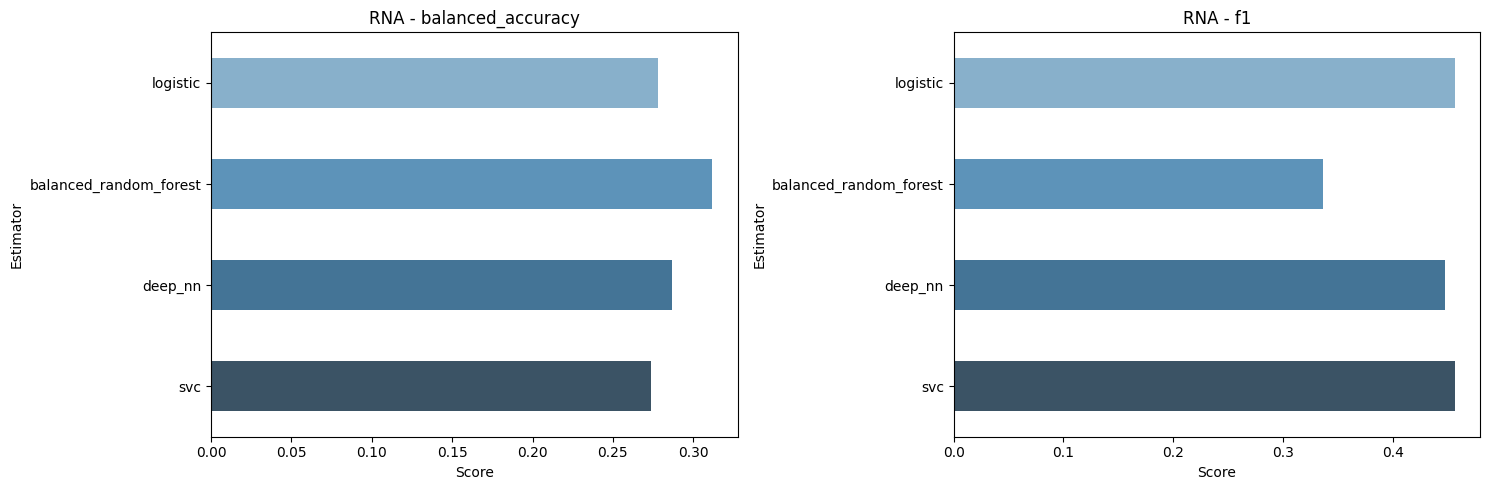

In [28]:

plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

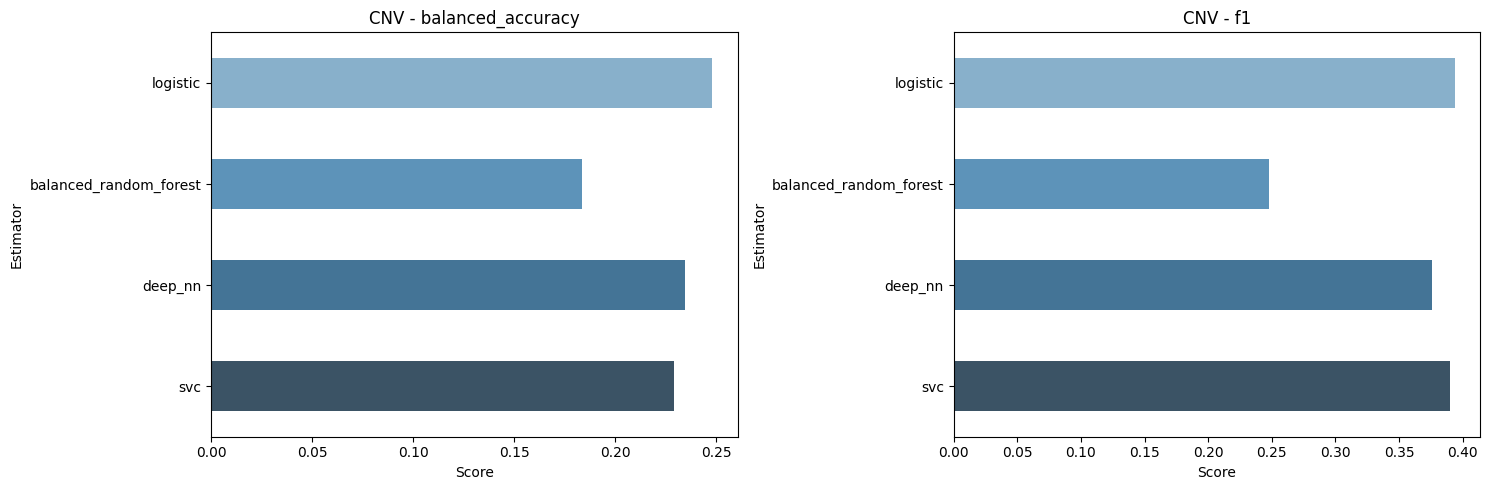

In [30]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

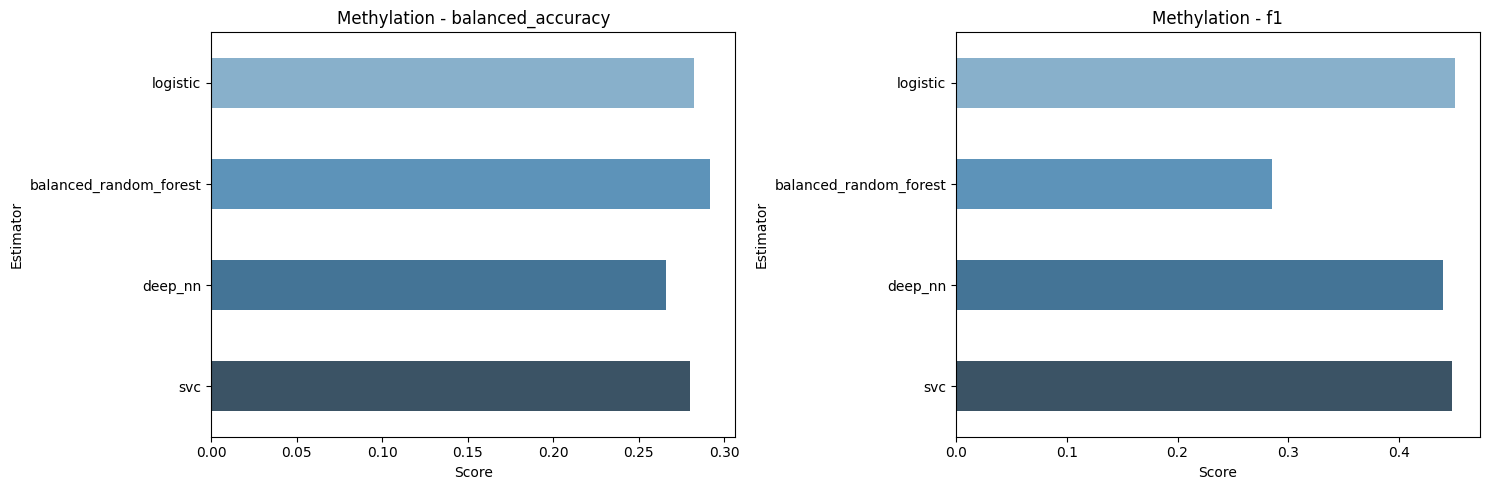

In [31]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

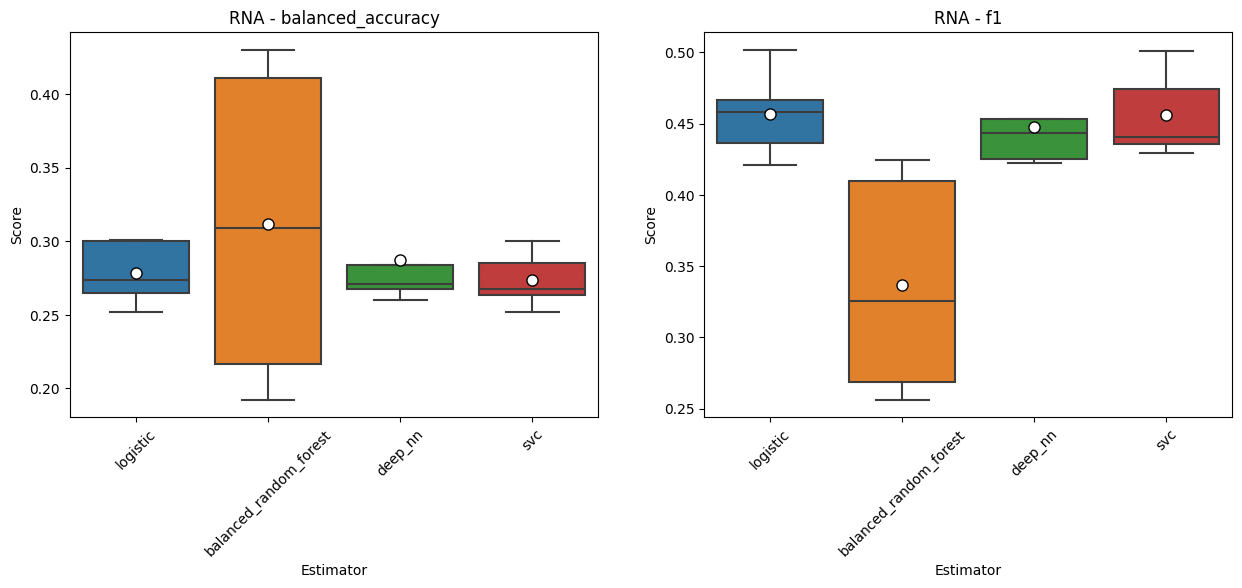

In [32]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

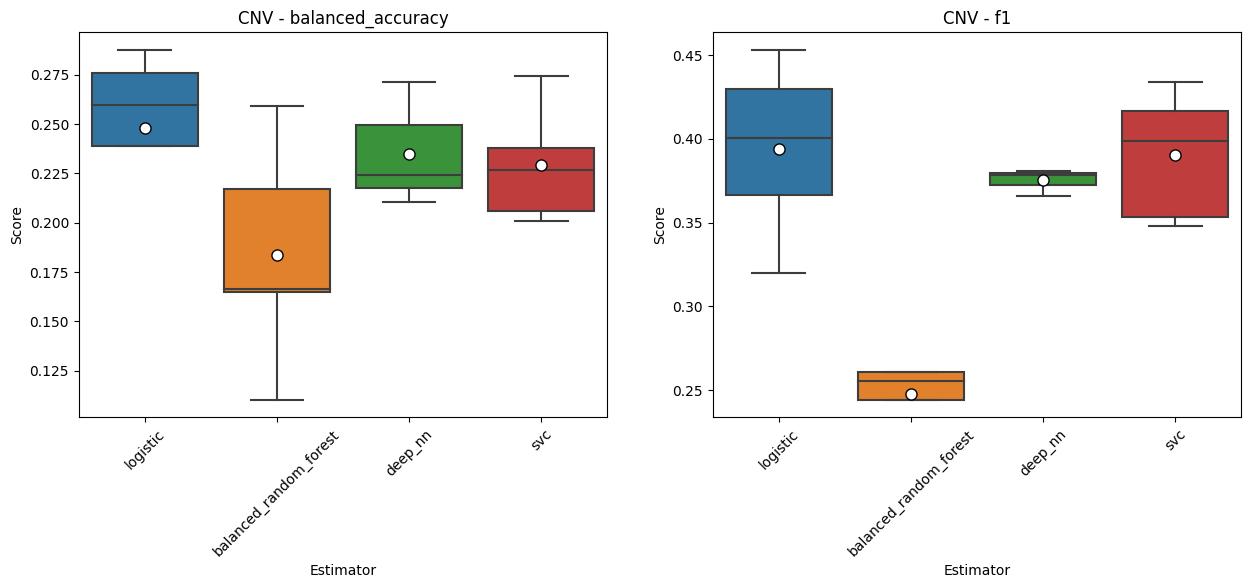

In [33]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

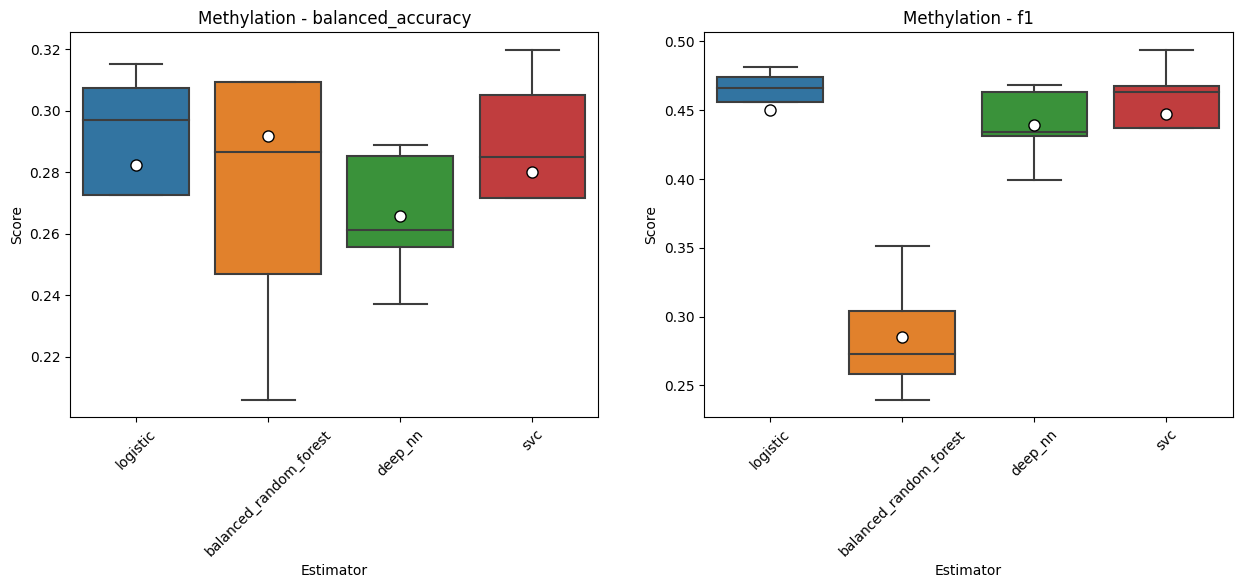

In [34]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

# Modality Ensembles

In [37]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [38]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [37]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (i)': make_scorer(recall_multiclass, label=0), 'recall (ii)': make_scorer(recall_multiclass, label=1), 'recall (iii)': make_scorer(recall_multiclass, label=2), 'recall (iv)': make_scorer(recall_multiclass, label=3)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

            accuracy balanced_accuracy               f1       recall (i)  \
rna  0.538 +/- 0.014   0.257 +/- 0.019  0.408 +/- 0.028  0.955 +/- 0.024   

         recall (ii)     recall (iii)      recall (iv)  
rna  0.045 +/- 0.041  0.027 +/- 0.053  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

            accuracy balanced_accuracy               f1       recall (i)  \
cnv  0.545 +/- 0.010   0.261 +/- 0.012  0.416 +/- 0.023  0.959 +/- 0.029   

         recall (ii)     recall (iii)      recall (iv)  
cnv  0.072 +/- 0.074  0.014 +/- 0.029  0.000 +/- 0.000  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True`

                    accuracy balanced_accuracy               f1  \
methylation  0.543 +/- 0.020   0.270 +/- 0.023  0.430 +/- 0.038   

                  recall (i)      recall (ii)     recall (iii)  \
methylation  0.935 +/- 0.057  0.091 +/- 0.065  0.055 +/- 0.068   

                 recall (iv)  
methylation  0.000 +/- 0.000  


In [39]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (short term)': make_scorer(recall_multiclass, label=0), 'recall (long term)': make_scorer(recall_multiclass, label=1)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed 

            accuracy balanced_accuracy               f1 recall (short term)  \
rna  0.373 +/- 0.035   0.374 +/- 0.035  0.368 +/- 0.033     0.416 +/- 0.074   

    recall (long term)  
rna    0.289 +/- 0.057  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True`

            accuracy balanced_accuracy               f1 recall (short term)  \
cnv  0.345 +/- 0.034   0.345 +/- 0.034  0.336 +/- 0.040     0.332 +/- 0.127   

    recall (long term)  
cnv    0.436 +/- 0.098  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

                    accuracy balanced_accuracy               f1  \
methylation  0.409 +/- 0.033   0.408 +/- 0.032  0.403 +/- 0.029   

            recall (short term) recall (long term)  
methylation     0.485 +/- 0.041    0.288 +/- 0.063  


In [38]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
rna,0.538 +/- 0.014,0.257 +/- 0.019,0.408 +/- 0.028,0.955 +/- 0.024,0.045 +/- 0.041,0.027 +/- 0.053,0.000 +/- 0.000
cnv,0.545 +/- 0.010,0.261 +/- 0.012,0.416 +/- 0.023,0.959 +/- 0.029,0.072 +/- 0.074,0.014 +/- 0.029,0.000 +/- 0.000
methylation,0.543 +/- 0.020,0.270 +/- 0.023,0.430 +/- 0.038,0.935 +/- 0.057,0.091 +/- 0.065,0.055 +/- 0.068,0.000 +/- 0.000


In [40]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (short term),recall (long term)
rna,0.373 +/- 0.035,0.374 +/- 0.035,0.368 +/- 0.033,0.416 +/- 0.074,0.289 +/- 0.057
cnv,0.345 +/- 0.034,0.345 +/- 0.034,0.336 +/- 0.040,0.332 +/- 0.127,0.436 +/- 0.098
methylation,0.409 +/- 0.033,0.408 +/- 0.032,0.403 +/- 0.029,0.485 +/- 0.041,0.288 +/- 0.063


In [41]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['cnv'].append(scores['cnv'])
all_scores['methylation'].append(scores['methylation'])

In [42]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [41]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.502 +/- 0.030,0.278 +/- 0.019,0.457 +/- 0.028,0.791 +/- 0.055,0.198 +/- 0.032,0.125 +/- 0.089,0.000 +/- 0.000
balanced_random_forest,0.301 +/- 0.065,0.312 +/- 0.097,0.337 +/- 0.070,0.340 +/- 0.047,0.225 +/- 0.123,0.250 +/- 0.113,0.433 +/- 0.162
deep_nn,0.469 +/- 0.025,0.287 +/- 0.034,0.448 +/- 0.026,0.676 +/- 0.030,0.251 +/- 0.056,0.221 +/- 0.134,0.000 +/- 0.000
svc,0.502 +/- 0.029,0.274 +/- 0.017,0.456 +/- 0.027,0.803 +/- 0.052,0.180 +/- 0.029,0.111 +/- 0.069,0.000 +/- 0.000
rna,0.538 +/- 0.014,0.257 +/- 0.019,0.408 +/- 0.028,0.955 +/- 0.024,0.045 +/- 0.041,0.027 +/- 0.053,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.395 +/- 0.049,0.248 +/- 0.039,0.394 +/- 0.047,0.554 +/- 0.066,0.243 +/- 0.062,0.195 +/- 0.067,0.000 +/- 0.000
balanced_random_forest,0.211 +/- 0.034,0.184 +/- 0.051,0.248 +/- 0.038,0.201 +/- 0.035,0.225 +/- 0.048,0.259 +/- 0.151,0.050 +/- 0.100
deep_nn,0.388 +/- 0.007,0.235 +/- 0.023,0.376 +/- 0.006,0.586 +/- 0.038,0.189 +/- 0.032,0.113 +/- 0.097,0.050 +/- 0.100
svc,0.399 +/- 0.035,0.229 +/- 0.026,0.390 +/- 0.034,0.595 +/- 0.058,0.253 +/- 0.064,0.070 +/- 0.045,0.000 +/- 0.000
cnv,0.545 +/- 0.010,0.261 +/- 0.012,0.416 +/- 0.023,0.959 +/- 0.029,0.072 +/- 0.074,0.014 +/- 0.029,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
logistic,0.518 +/- 0.031,0.282 +/- 0.035,0.450 +/- 0.039,0.848 +/- 0.025,0.100 +/- 0.053,0.181 +/- 0.127,0.000 +/- 0.000
balanced_random_forest,0.251 +/- 0.037,0.292 +/- 0.069,0.285 +/- 0.039,0.254 +/- 0.038,0.235 +/- 0.047,0.211 +/- 0.104,0.467 +/- 0.172
deep_nn,0.482 +/- 0.026,0.266 +/- 0.019,0.439 +/- 0.025,0.762 +/- 0.043,0.189 +/- 0.035,0.111 +/- 0.073,0.000 +/- 0.000
svc,0.513 +/- 0.030,0.280 +/- 0.035,0.447 +/- 0.041,0.836 +/- 0.039,0.118 +/- 0.085,0.167 +/- 0.126,0.000 +/- 0.000
methylation,0.543 +/- 0.020,0.270 +/- 0.023,0.430 +/- 0.038,0.935 +/- 0.057,0.091 +/- 0.065,0.055 +/- 0.068,0.000 +/- 0.000


In [43]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high),recall (short term),recall (long term)
logistic,0.357 +/- 0.024,0.358 +/- 0.024,0.353 +/- 0.019,0.289 +/- 0.042,0.339 +/- 0.086,0.445 +/- 0.102,NaN,NaN
balanced_random_forest,0.392 +/- 0.055,0.392 +/- 0.054,0.391 +/- 0.059,0.359 +/- 0.065,0.402 +/- 0.127,0.415 +/- 0.050,NaN,NaN
deep_nn,0.333 +/- 0.041,0.334 +/- 0.041,0.333 +/- 0.041,0.324 +/- 0.077,0.303 +/- 0.046,0.374 +/- 0.076,NaN,NaN
svc,0.357 +/- 0.033,0.358 +/- 0.034,0.353 +/- 0.030,0.310 +/- 0.026,0.303 +/- 0.093,0.459 +/- 0.106,NaN,NaN
rna,0.373 +/- 0.035,0.374 +/- 0.035,0.368 +/- 0.033,NaN,NaN,NaN,0.416 +/- 0.074,0.289 +/- 0.057


,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high),recall (short term),recall (long term)
logistic,0.352 +/- 0.059,0.352 +/- 0.059,0.349 +/- 0.058,0.366 +/- 0.125,0.339 +/- 0.097,0.352 +/- 0.080,NaN,NaN
balanced_random_forest,0.385 +/- 0.028,0.385 +/- 0.028,0.382 +/- 0.029,0.465 +/- 0.020,0.346 +/- 0.115,0.345 +/- 0.041,NaN,NaN
deep_nn,0.352 +/- 0.064,0.353 +/- 0.065,0.349 +/- 0.062,0.302 +/- 0.091,0.346 +/- 0.085,0.410 +/- 0.091,NaN,NaN
svc,0.357 +/- 0.021,0.357 +/- 0.021,0.353 +/- 0.020,0.323 +/- 0.100,0.339 +/- 0.077,0.409 +/- 0.049,NaN,NaN
cnv,0.345 +/- 0.034,0.345 +/- 0.034,0.336 +/- 0.040,NaN,NaN,NaN,0.332 +/- 0.127,0.436 +/- 0.098


,accuracy,balanced_accuracy,f1,recall (low),recall (medium),recall (high),recall (short term),recall (long term)
logistic,0.413 +/- 0.057,0.414 +/- 0.057,0.413 +/- 0.058,0.367 +/- 0.071,0.417 +/- 0.113,0.458 +/- 0.045,NaN,NaN
balanced_random_forest,0.404 +/- 0.047,0.404 +/- 0.047,0.400 +/- 0.046,0.359 +/- 0.048,0.459 +/- 0.074,0.394 +/- 0.143,NaN,NaN
deep_nn,0.418 +/- 0.026,0.418 +/- 0.027,0.418 +/- 0.027,0.394 +/- 0.047,0.445 +/- 0.096,0.416 +/- 0.075,NaN,NaN
svc,0.411 +/- 0.067,0.411 +/- 0.067,0.410 +/- 0.069,0.352 +/- 0.061,0.410 +/- 0.147,0.472 +/- 0.018,NaN,NaN
methylation,0.409 +/- 0.033,0.408 +/- 0.032,0.403 +/- 0.029,NaN,NaN,NaN,0.485 +/- 0.041,0.288 +/- 0.063


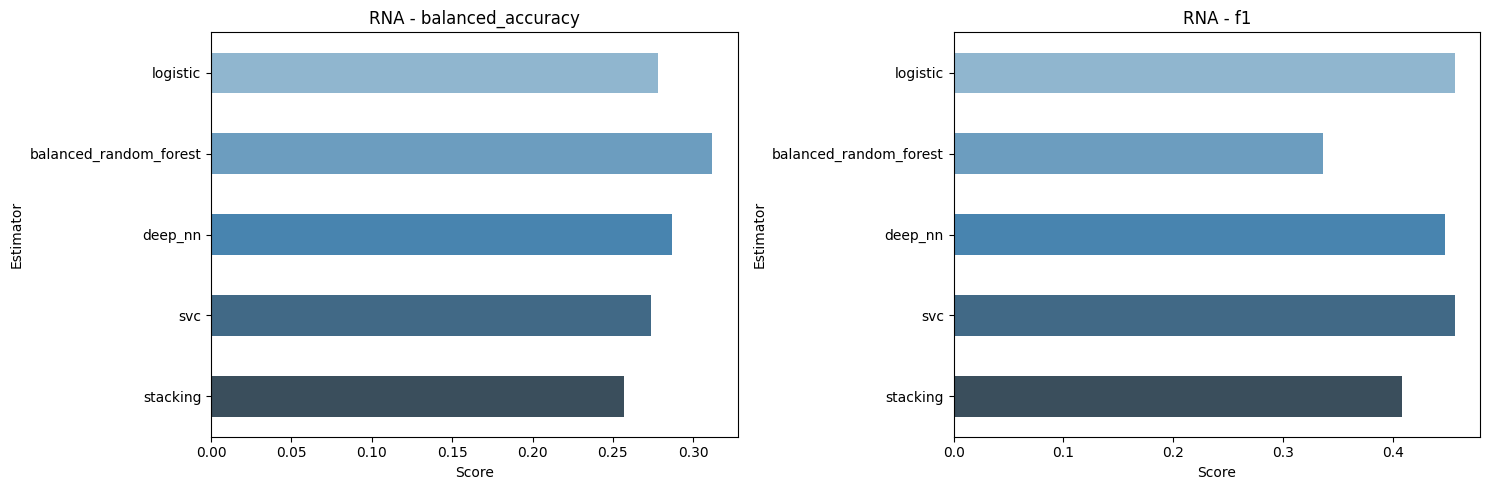

In [42]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

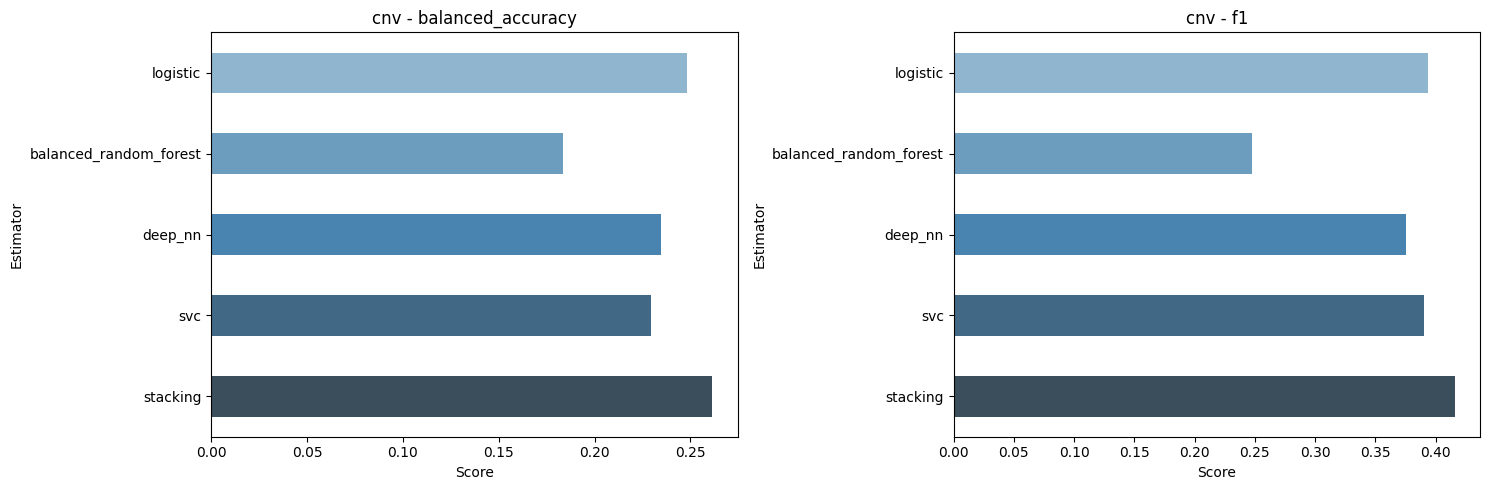

In [43]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'cnv', metrics=['balanced_accuracy', 'f1'])

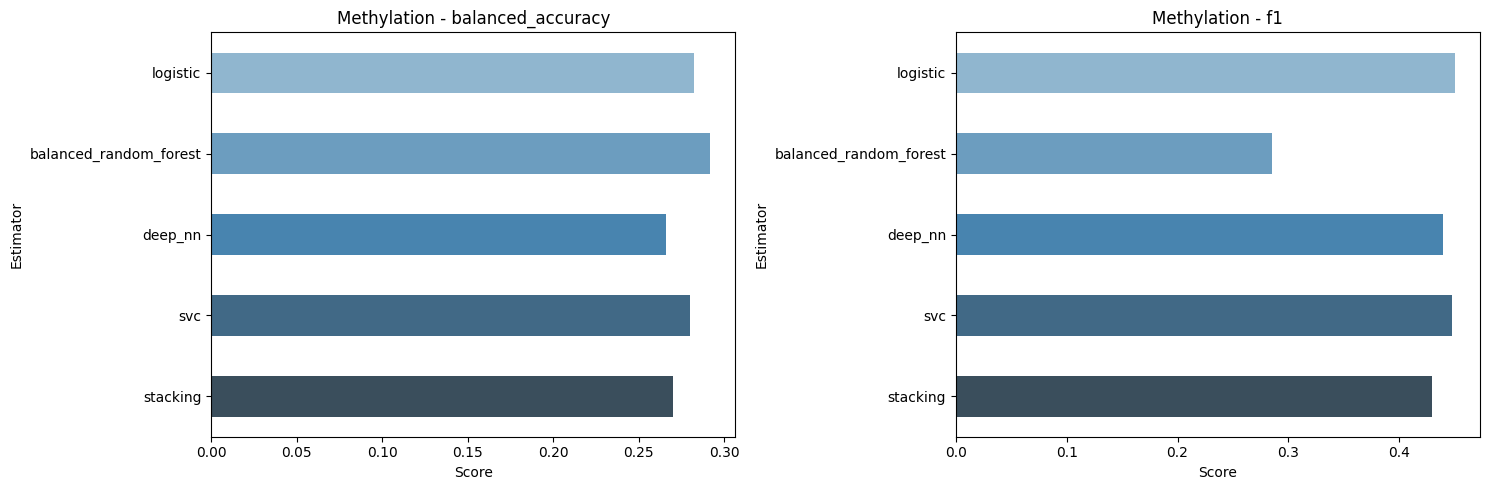

In [44]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

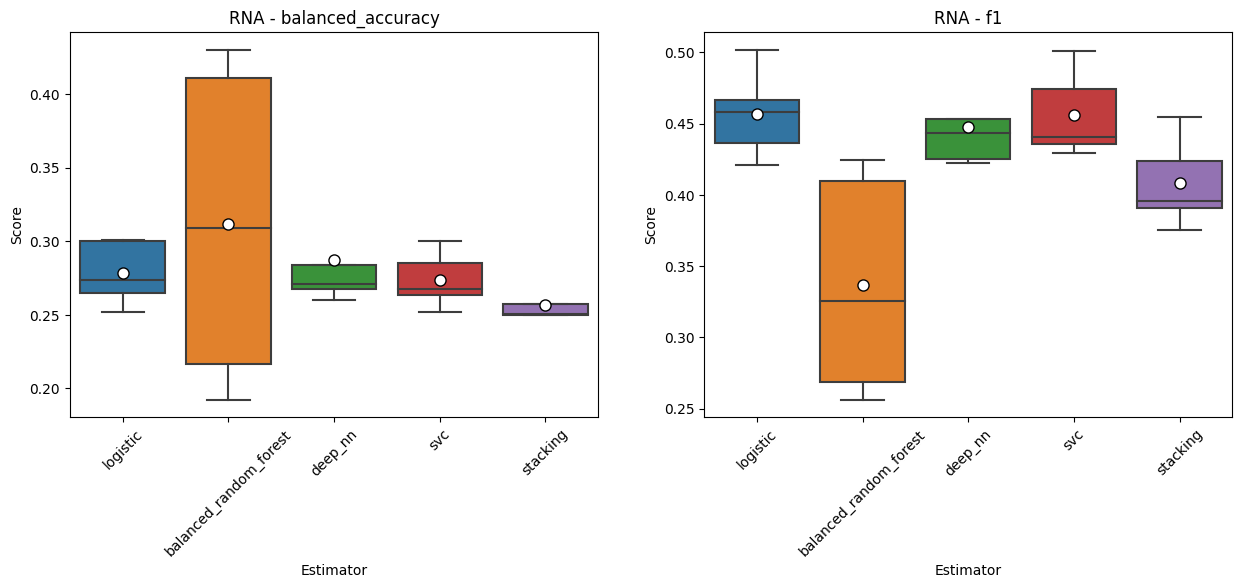

In [45]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

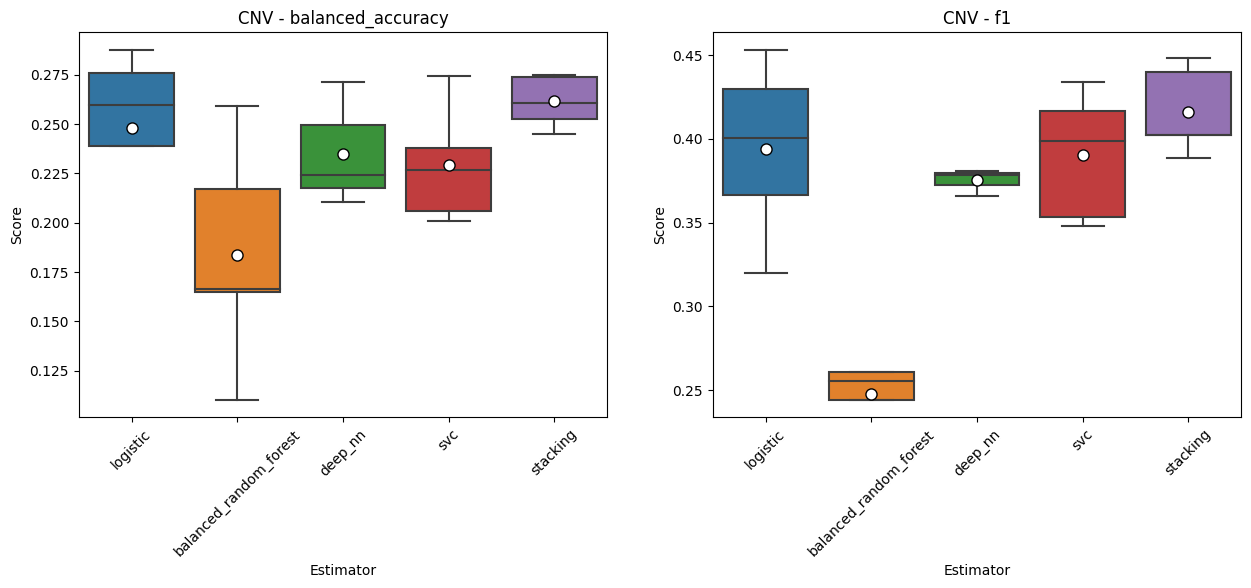

In [46]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

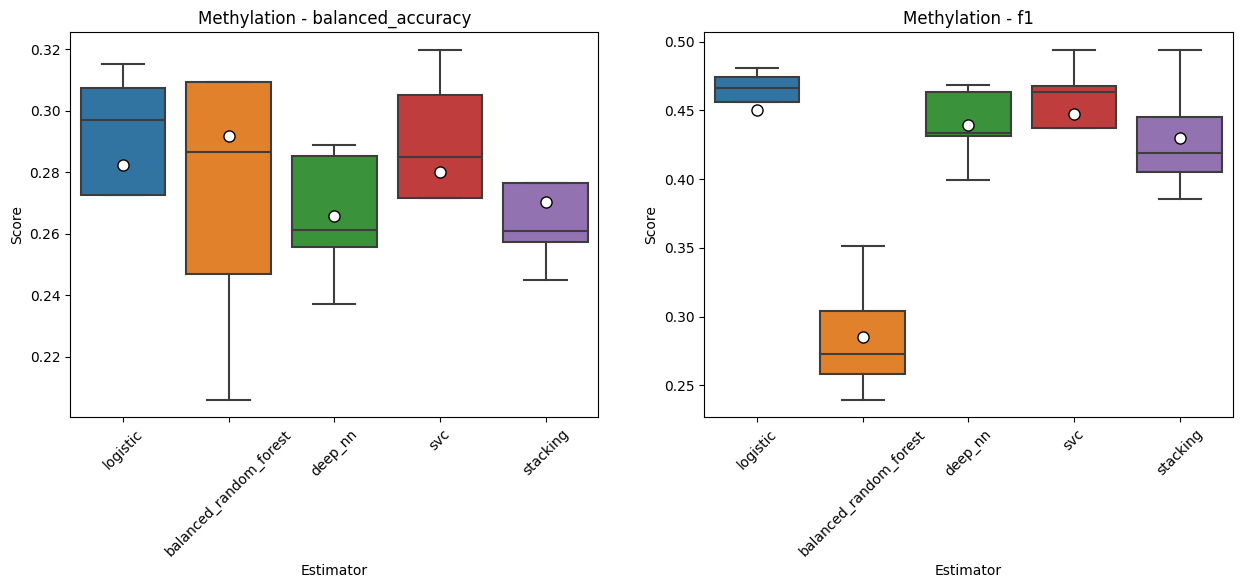

In [47]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

# Multi Omics Integration Ensemble

In [48]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed

In [49]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['cnv'].argmax(axis=1),
    'methylation': preds['methylation'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_i', 'rna_ii', 'rna_iii', 'rna_iv']), pd.DataFrame(preds['cnv'], columns=['mirna_i', 'mirna_ii', 'mirna_iii', 'mirna_iv']), pd.DataFrame(preds['methylation'], columns=['meth_i', 'meth_ii', 'meth_iii', 'meth_iv'])], axis=1)

## With Voting

Hard Voting:

In [50]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score

def calculate_voting_scores(preds_class_df, y, name):
    # Find the majority class for each sample
    majority_class = preds_class_df.mode(axis=1)[0]

    # Calculate the scores
    accuracy = accuracy_score(y, majority_class)
    balanced_accuracy = balanced_accuracy_score(y, majority_class)
    f1 = f1_score(y, majority_class, average='weighted')
    recall = recall_score(y, majority_class, average=None)

    # Create a DataFrame with the scores
    scores_df = pd.DataFrame({
        'accuracy': [accuracy],
        'balanced_accuracy': [balanced_accuracy],
        'f1': [f1],
        'recall (i)': [recall[0]],
        'recall (ii)': [recall[1]],
        'recall (iii)': [recall[2]],
        'recall (iv)': [recall[3]]
    })

    return scores_df.rename(index={0: name})

In [51]:
rna_mirna_meth = calculate_voting_scores(preds_class_df, y, 'rna_cnv_meth')
mirna_meth = calculate_voting_scores(preds_class_df[['cnv', 'methylation']], y, 'cnv_meth')
rna_meth = calculate_voting_scores(preds_class_df[['rna', 'methylation']], y, 'rna_meth')
rna_mirna = calculate_voting_scores(preds_class_df[['rna', 'cnv']], y, 'rna_cnv')

In [52]:
# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, rna_mirna_meth, mirna_meth, rna_meth, rna_mirna])
integration_voting_metrics

,accuracy,balanced_accuracy,f1,recall (i),recall (ii),recall (iii),recall (iv)
rna,0.538 +/- 0.014,0.257 +/- 0.019,0.408 +/- 0.028,0.955 +/- 0.024,0.045 +/- 0.041,0.027 +/- 0.053,0.000 +/- 0.000
cnv,0.545 +/- 0.010,0.261 +/- 0.012,0.416 +/- 0.023,0.959 +/- 0.029,0.072 +/- 0.074,0.014 +/- 0.029,0.000 +/- 0.000
methylation,0.543 +/- 0.020,0.270 +/- 0.023,0.430 +/- 0.038,0.935 +/- 0.057,0.091 +/- 0.065,0.055 +/- 0.068,0.000 +/- 0.000
rna_cnv_meth,0.549327,0.258375,0.403392,0.987705,0.018018,0.027778,0.0
cnv_meth,0.547085,0.253675,0.395305,0.991803,0.009009,0.013889,0.0
rna_meth,0.547085,0.256131,0.402123,0.983607,0.027027,0.013889,0.0
rna_cnv,0.547085,0.251228,0.390863,0.995902,0.009009,0.0,0.0


## With Stacking

In [58]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


In [59]:
integration_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
Integration Model,0.881 +/- 0.023,0.806 +/- 0.033,0.876 +/- 0.025,0.972 +/- 0.034,0.533 +/- 0.125,0.947 +/- 0.023,0.770 +/- 0.108


In [73]:
rna_mirna_meth_scores, rna_mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
mirna_meth_scores, mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_meth_scores, rna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='rna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_mirna_scores, rna_mirna_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB']], y, name='rna + mirna', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [74]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_mirna_meth_df, mirna_meth_df, rna_meth_df, rna_mirna_df])

In [75]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.907 +/- 0.030,0.886 +/- 0.053,0.905 +/- 0.032,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.790 +/- 0.111
mirna,0.816 +/- 0.027,0.774 +/- 0.046,0.808 +/- 0.032,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.570 +/- 0.150
methylation,0.835 +/- 0.055,0.809 +/- 0.065,0.832 +/- 0.060,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.038,0.660 +/- 0.169
rna + mirna + methylation,0.905 +/- 0.020,0.891 +/- 0.034,0.904 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.067,0.943 +/- 0.023,0.780 +/- 0.093
mirna + methylation,0.830 +/- 0.036,0.802 +/- 0.054,0.826 +/- 0.037,0.958 +/- 0.057,0.733 +/- 0.170,0.895 +/- 0.063,0.620 +/- 0.121
rna + methylation,0.909 +/- 0.017,0.888 +/- 0.031,0.908 +/- 0.019,0.972 +/- 0.034,0.833 +/- 0.149,0.948 +/- 0.018,0.800 +/- 0.105
rna + mirna,0.907 +/- 0.024,0.874 +/- 0.040,0.905 +/- 0.026,0.972 +/- 0.034,0.767 +/- 0.170,0.947 +/- 0.023,0.810 +/- 0.111


In [76]:
names = ['rna', 'mirna', 'methylation', 'rna + mirna + meth', 'mirna + meth', 'rna + meth', 'rna + mirna']
integration = []
integration.append(scores['rna'])
integration.append(scores['mirna'])
integration.append(scores['methylation'])
integration.append(rna_mirna_meth_scores)
integration.append(mirna_meth_scores)
integration.append(rna_meth_scores)
integration.append(rna_mirna_scores)

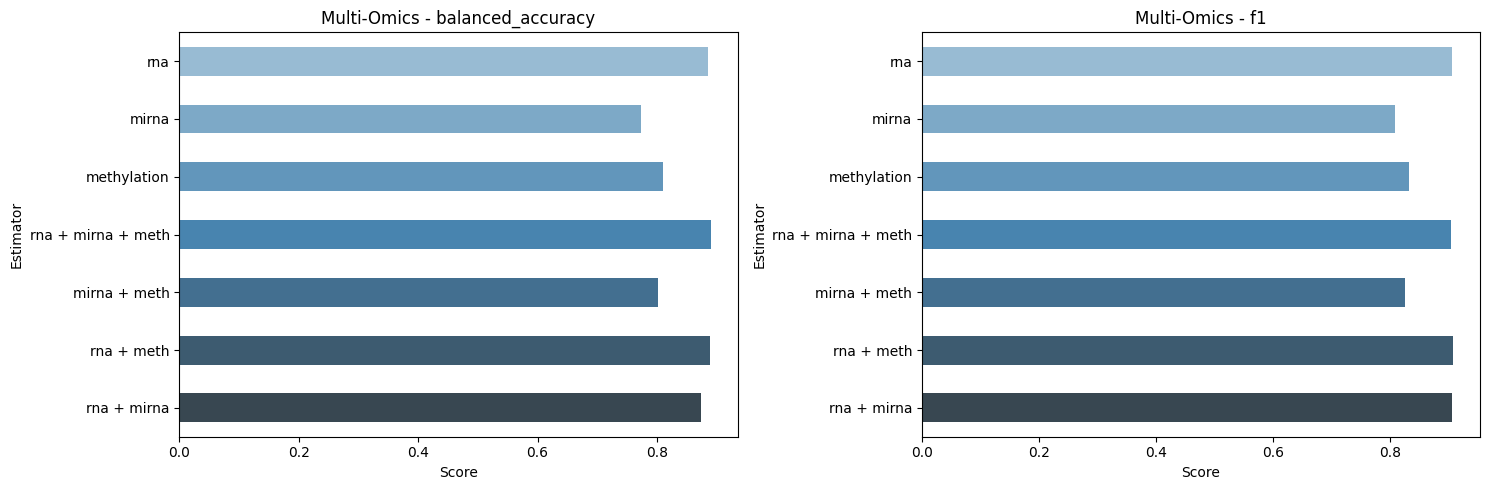

In [77]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

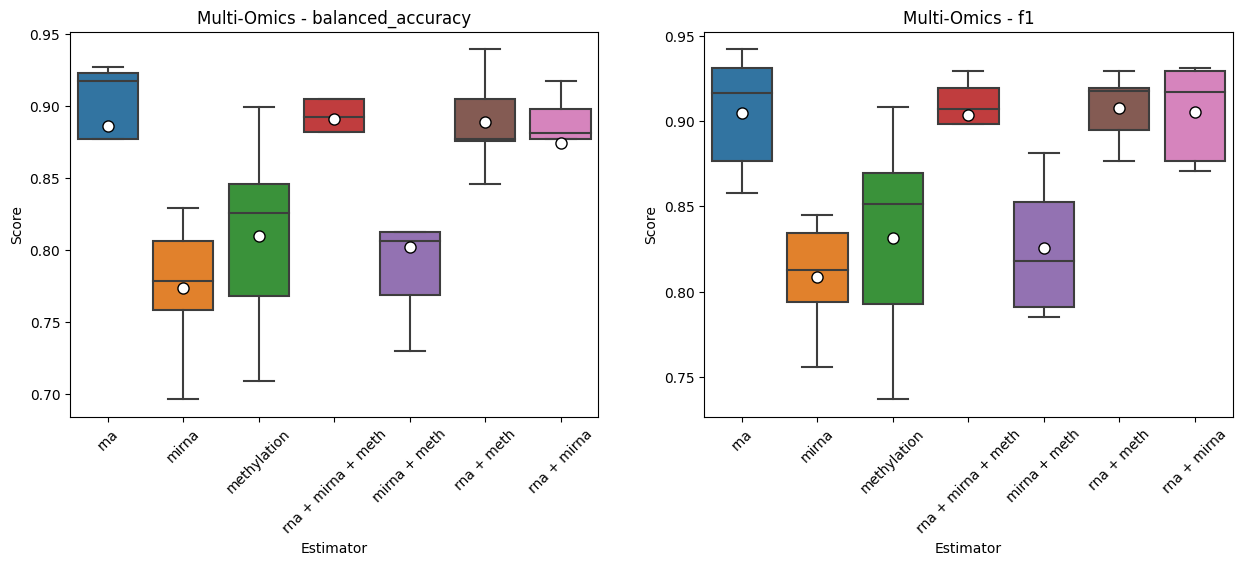

In [78]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])